## Imports and Setup

In [2]:
import os 
os.chdir('../')
from utils import plot_utils
from utils import post_utils
from utils import config_utils

%load_ext autoreload
%autoreload 2

## Load Config Files

In [14]:
iso_code = "MOZ"
data_config_file = os.path.join(os.getcwd(), "configs/data_configs/data_config_ISO_AF.yaml")
data_config = config_utils.load_config(data_config_file)

## Load Data

In [36]:
master = post_utils.read_file(iso_code, source="master")
osm = post_utils.read_file(iso_code, source="osm_overture")
preds = post_utils.read_file(iso_code, cam_method="gradcamelementwise", source="preds")
print(preds.shape)
preds.head(2)

(43420, 9)


,prob,UID,sum,group,ADM1,ADM2,ADM3,PUID,geometry
0,0.98088,7658,62.0,3041,Manica,Cidade De Chimoio,Cidade De Chimoio,Cidade De Chimoio_7658,POINT (3725889.788 -2169592.396)
1,0.98079,24801,50.0,21603,Sofala,Cidade Da Beira,Cidade Da Beira,Cidade Da Beira_24801,POINT (3882453.658 -2246136.740)


## Analyse Government vs AI Prediction Results

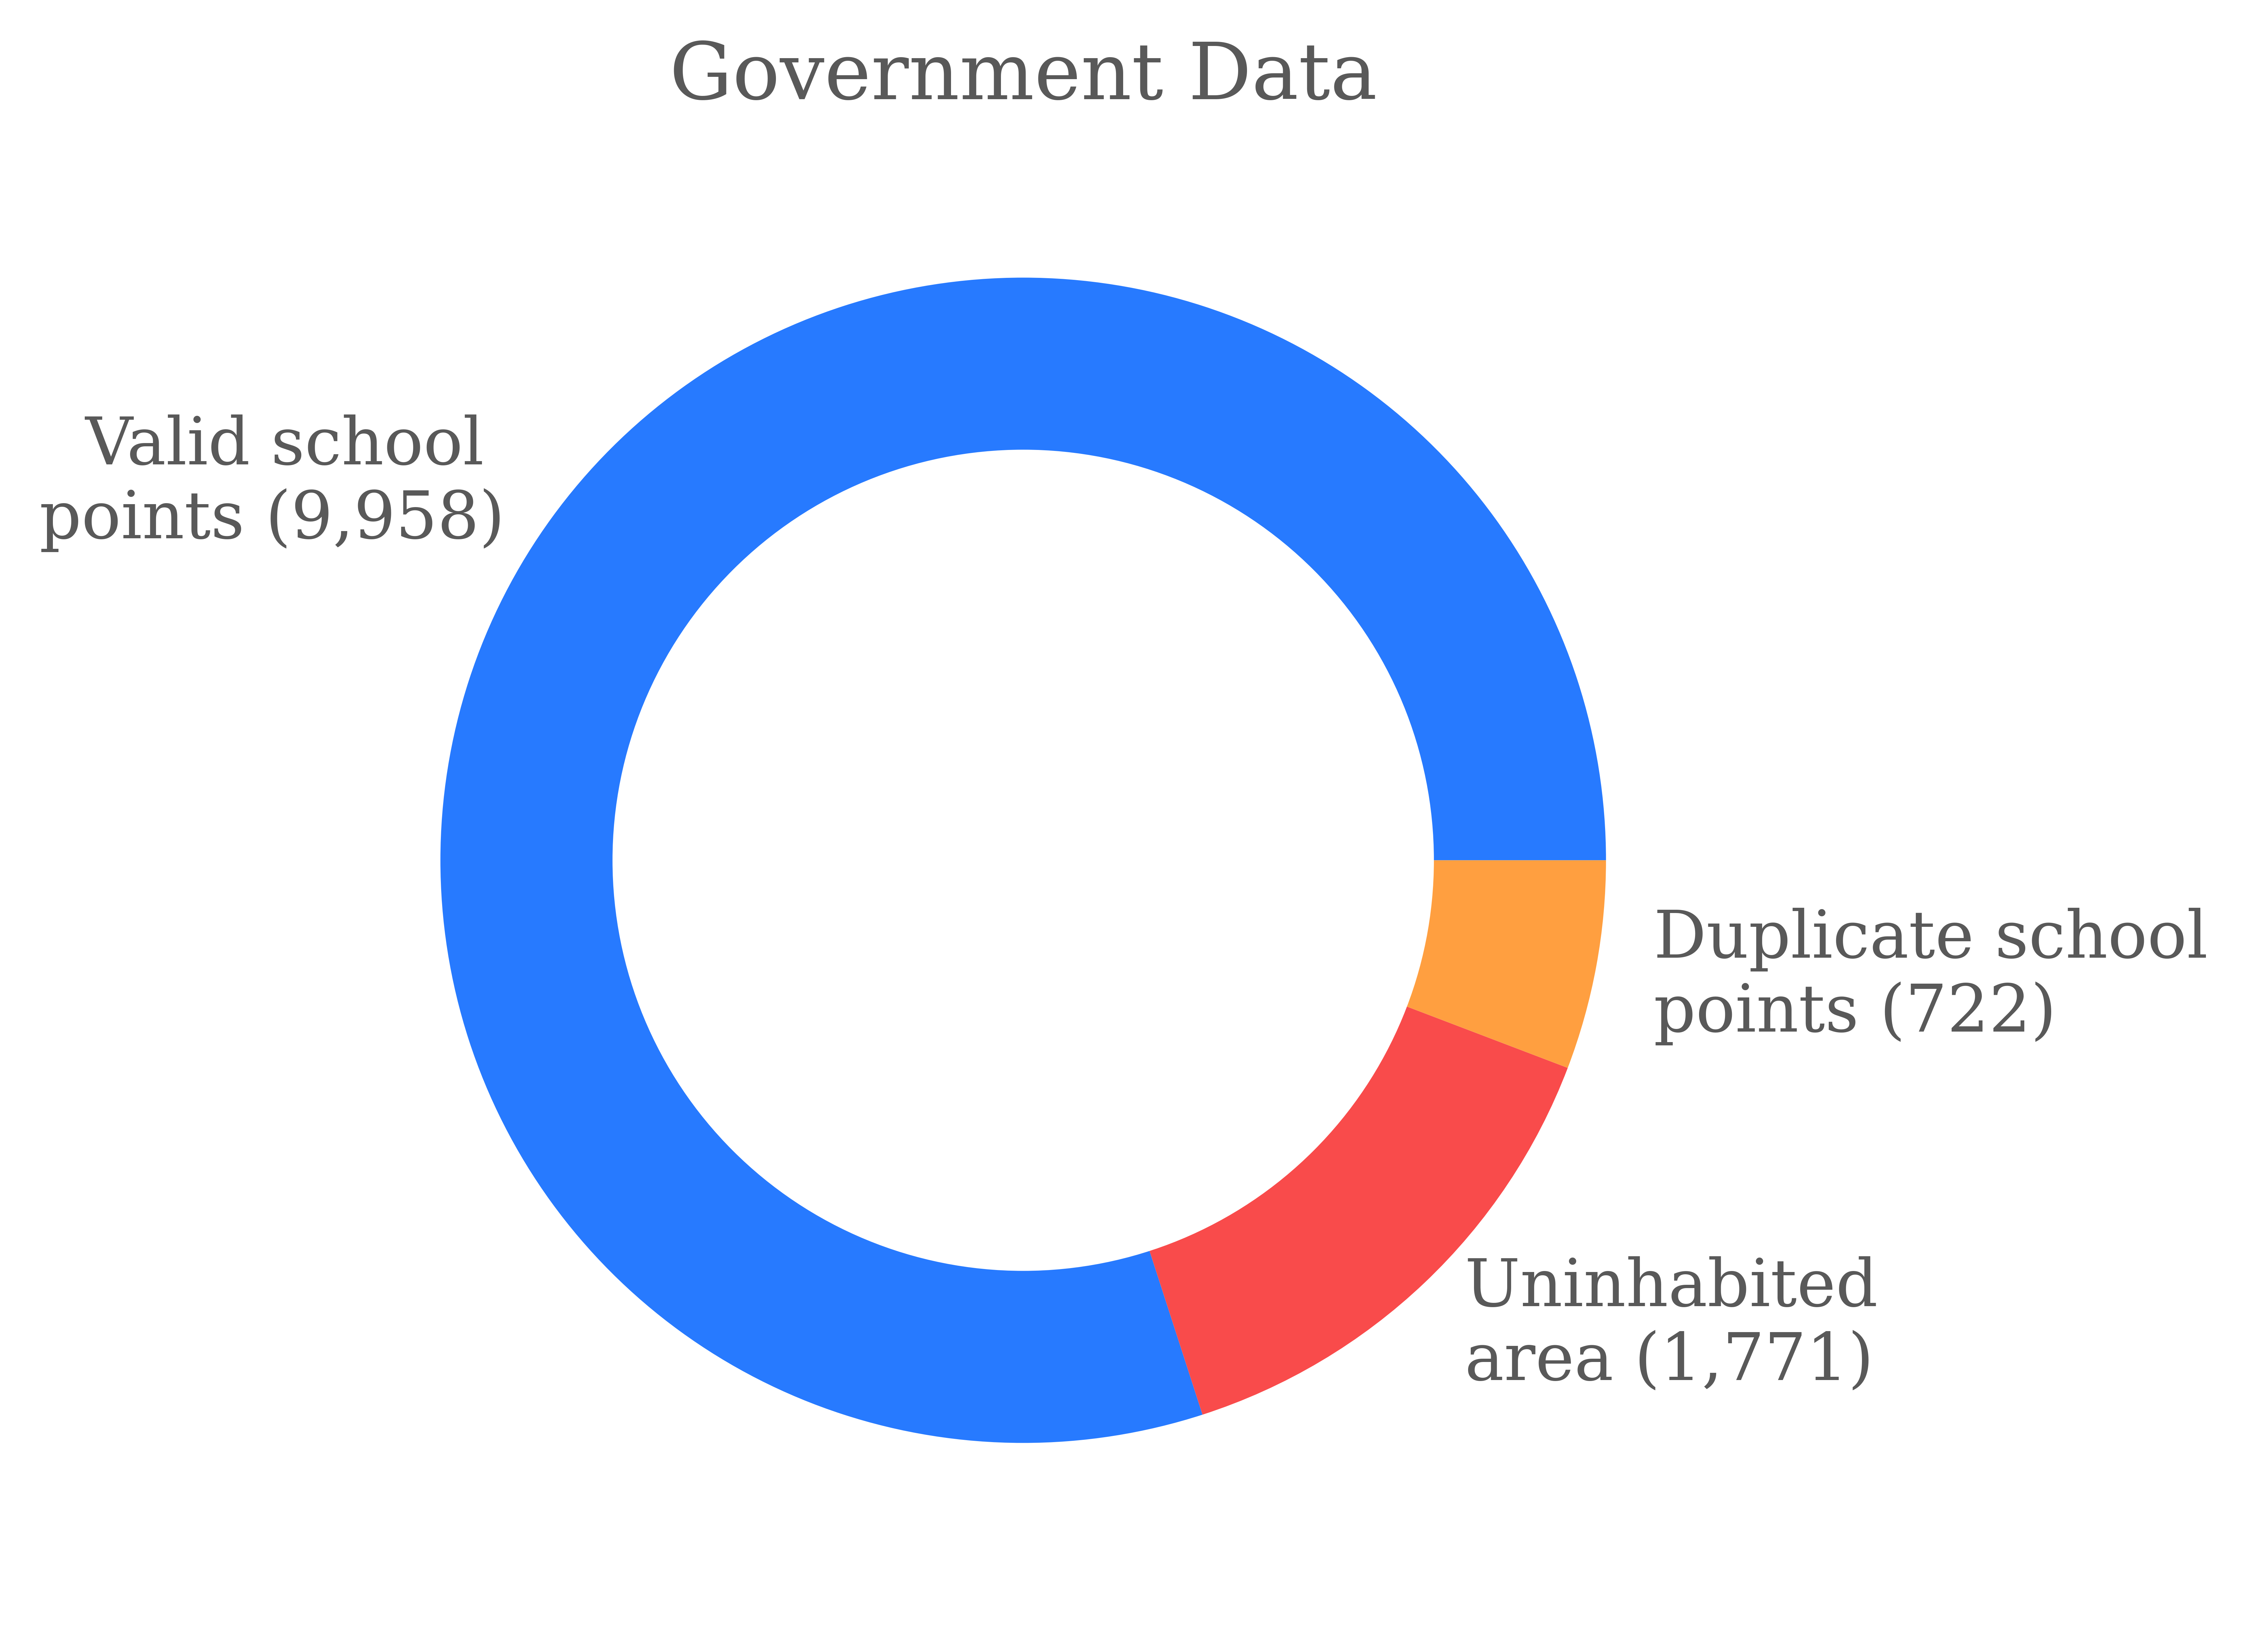

In [40]:
plot_utils.plot_pie_chart(master, source="master")

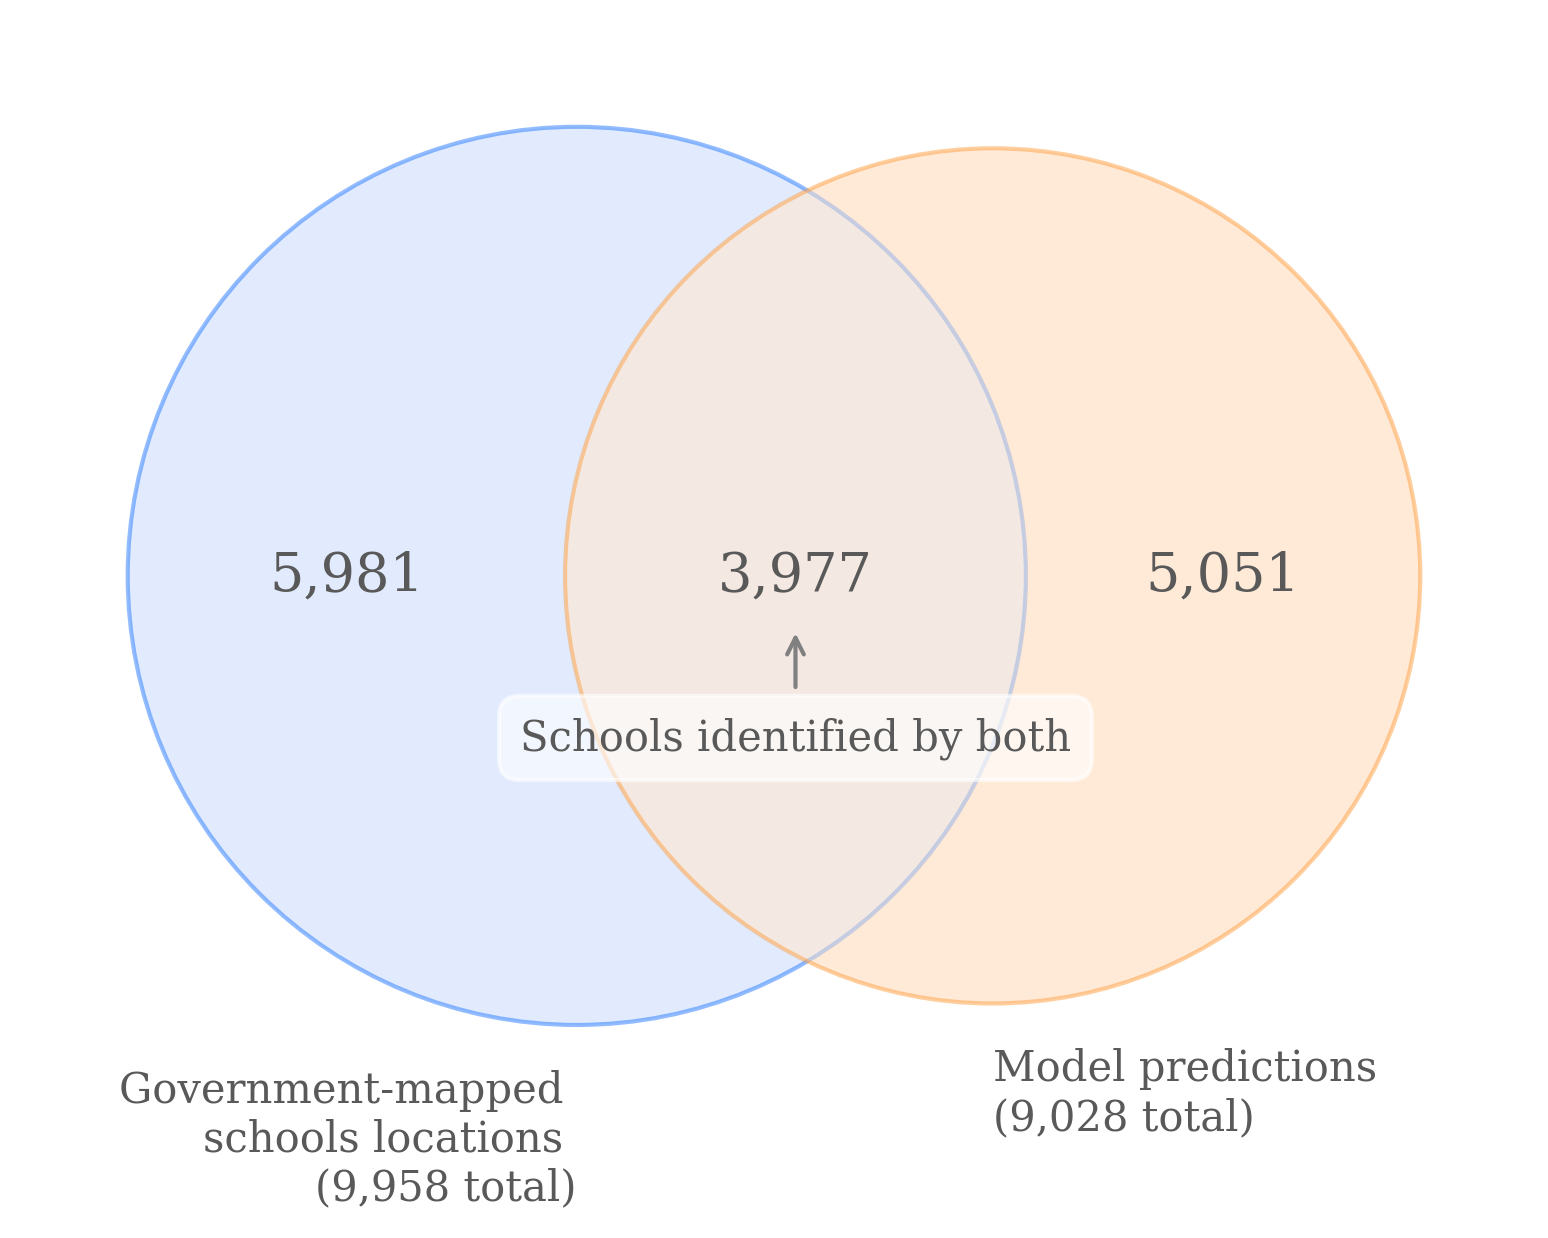

In [43]:
plot_utils.plot_venn_diagram(master, preds[preds.prob > 0.9], threshold_dist=250)

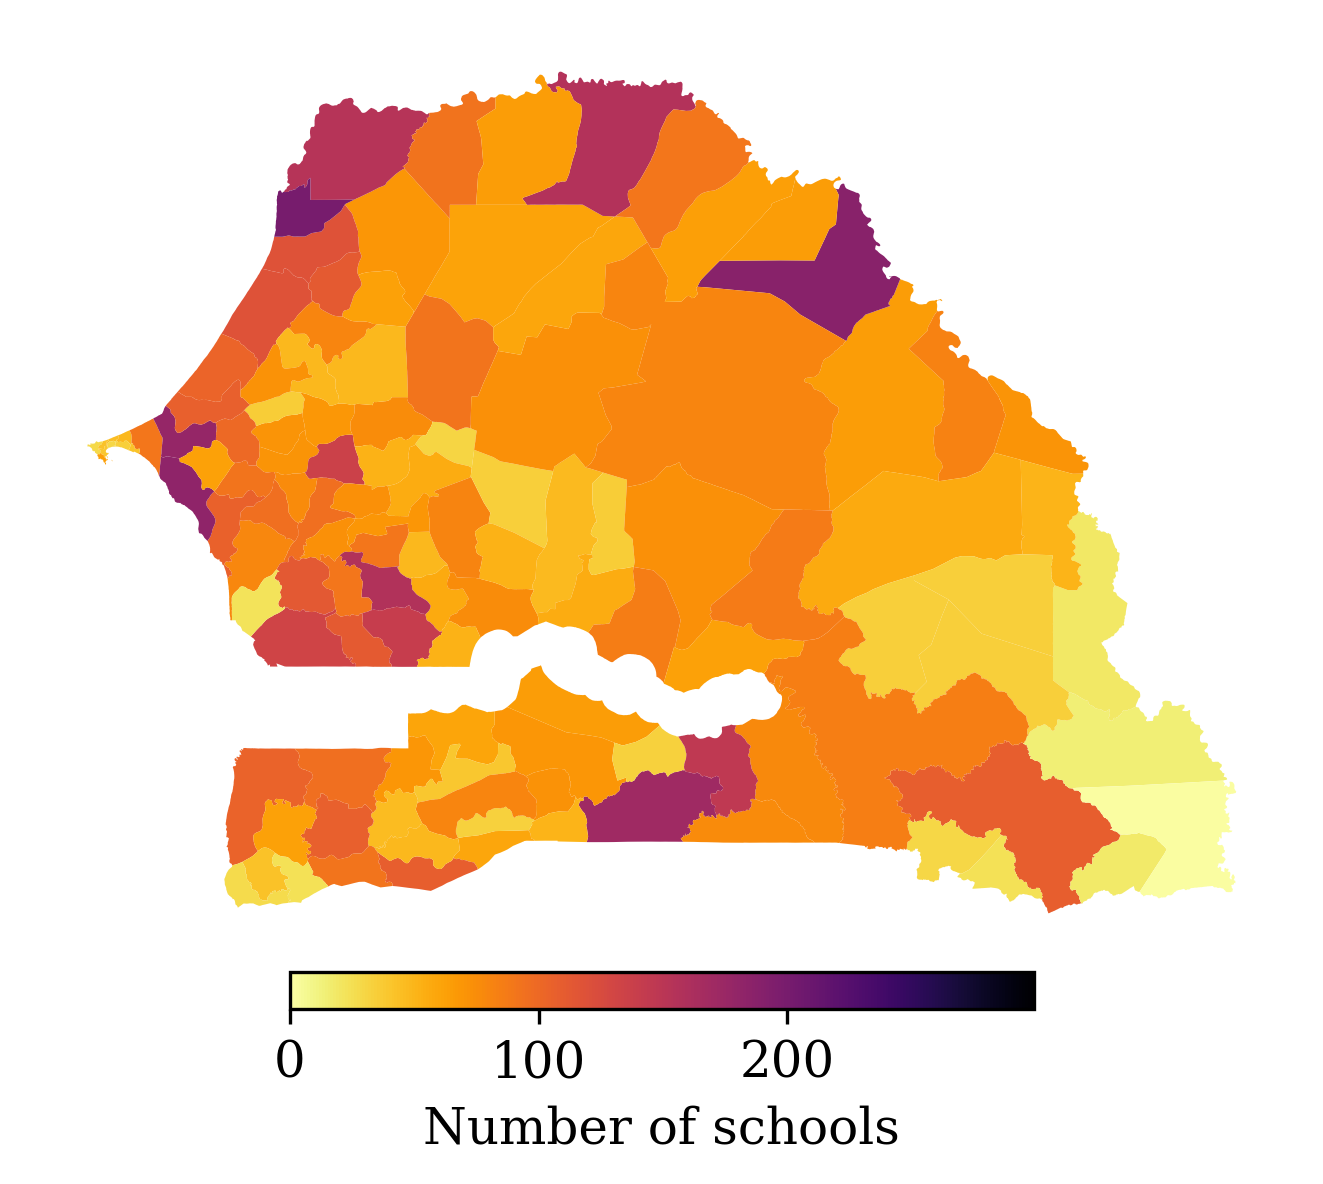

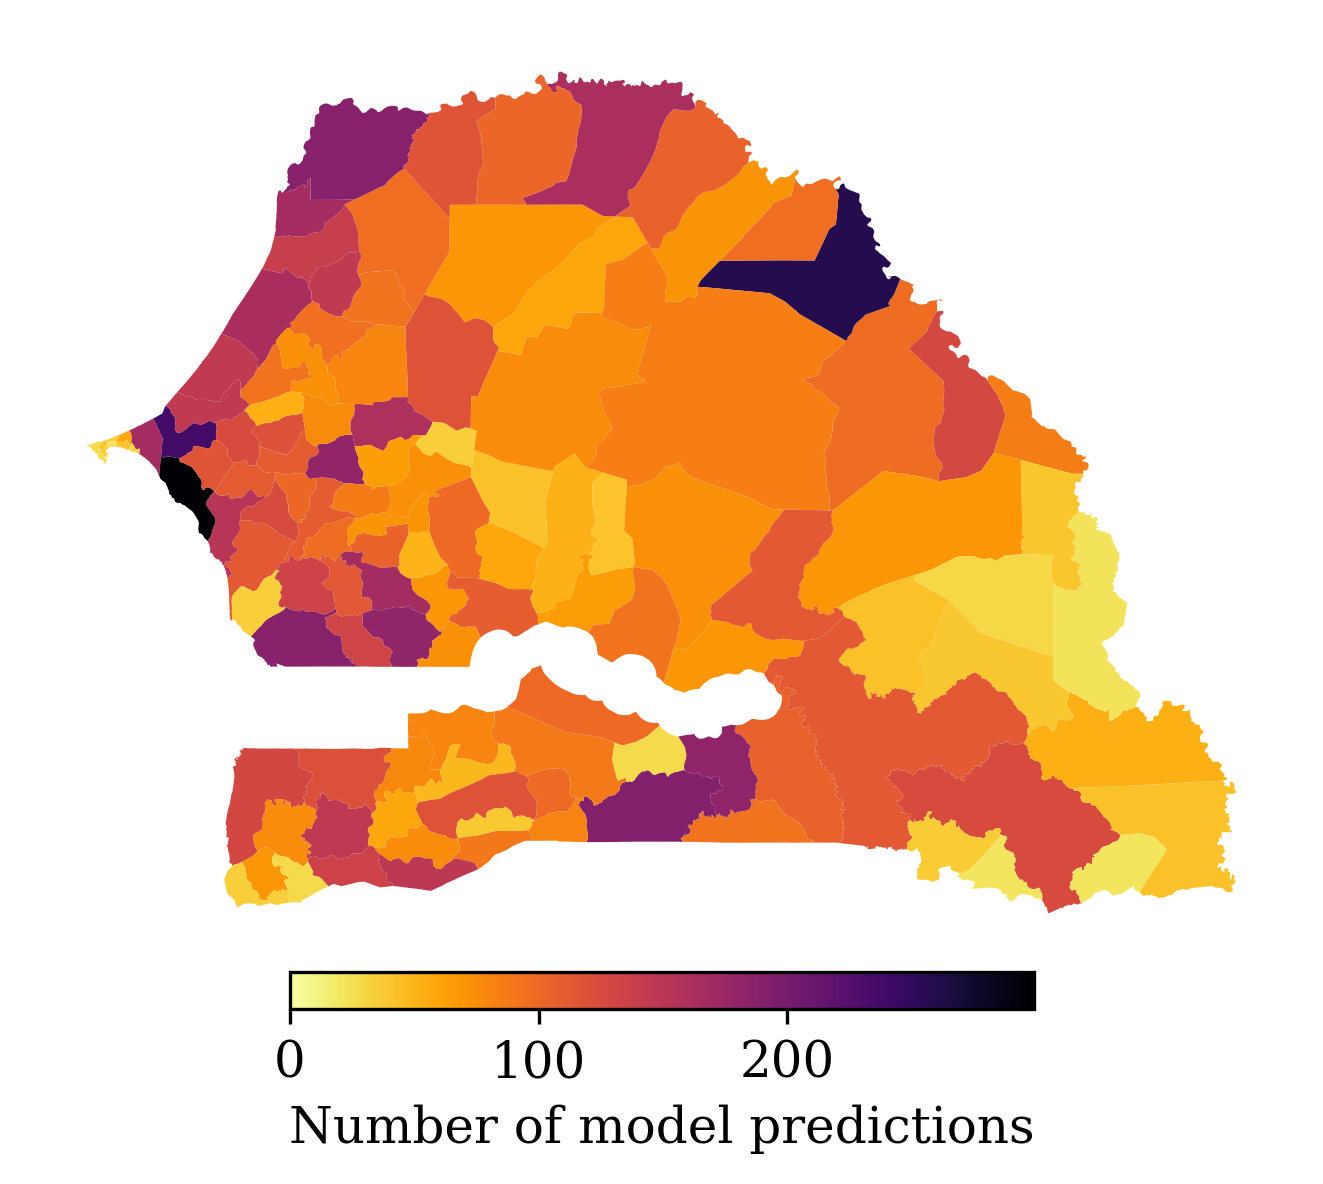

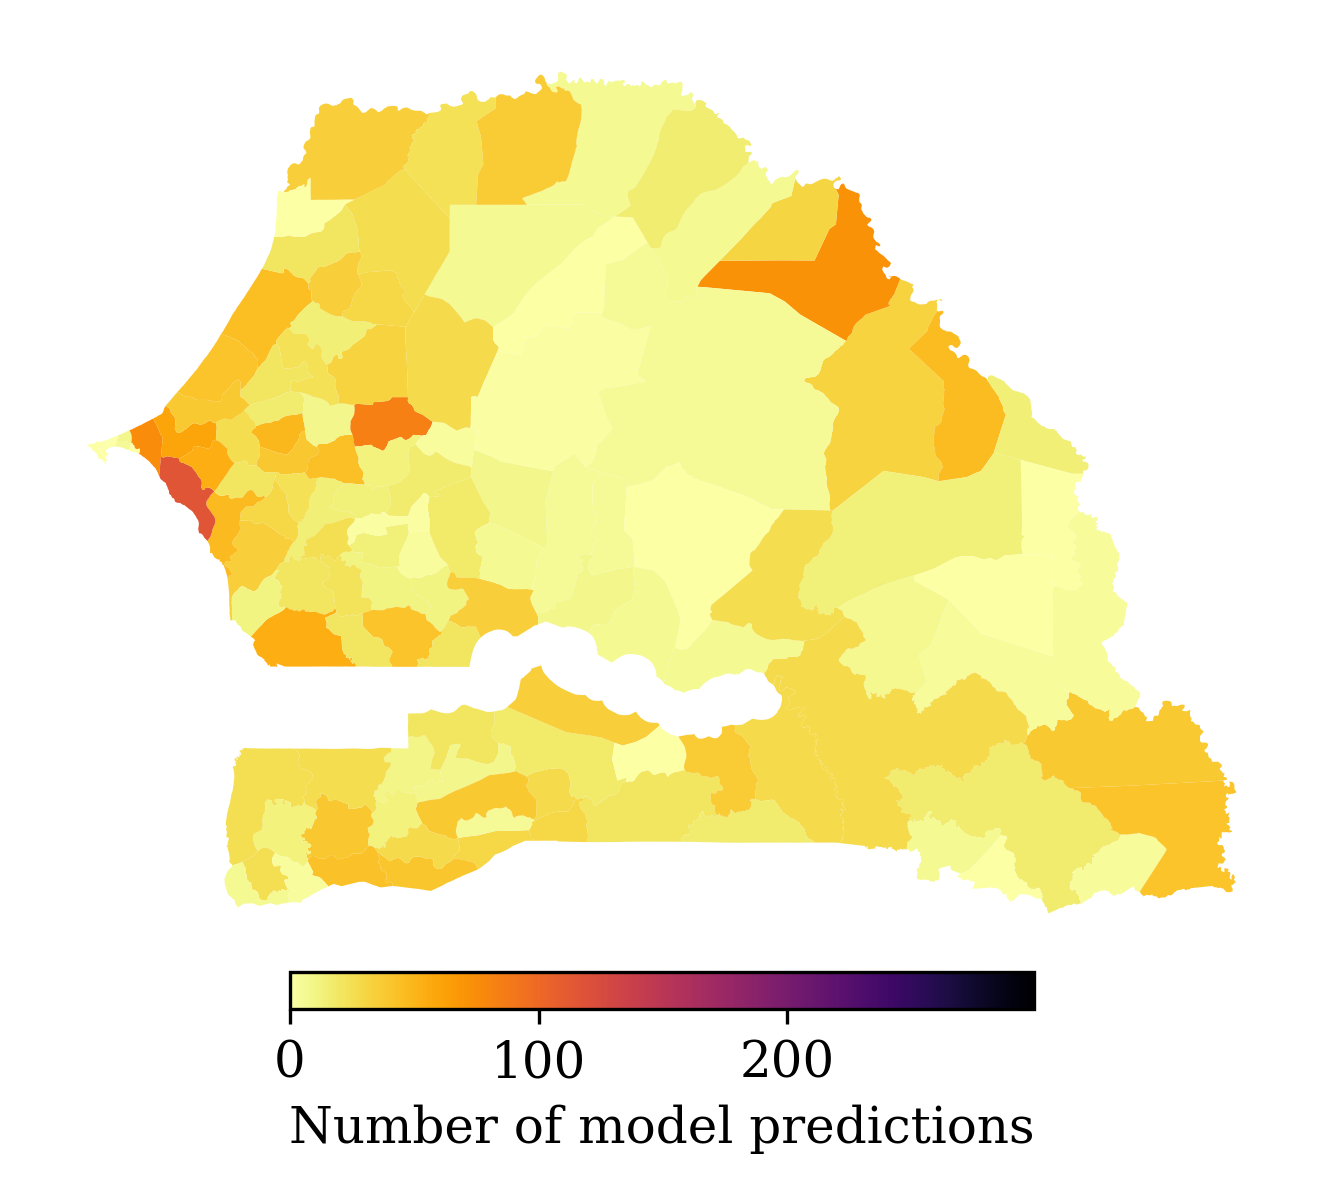

In [61]:
plot_utils.plot_choropleth(master, preds[preds.prob > 0.5], data_config, iso_code, threshold_dist=250, adm_level="ADM3")

## Plot Charts for Post-prediction Analysis

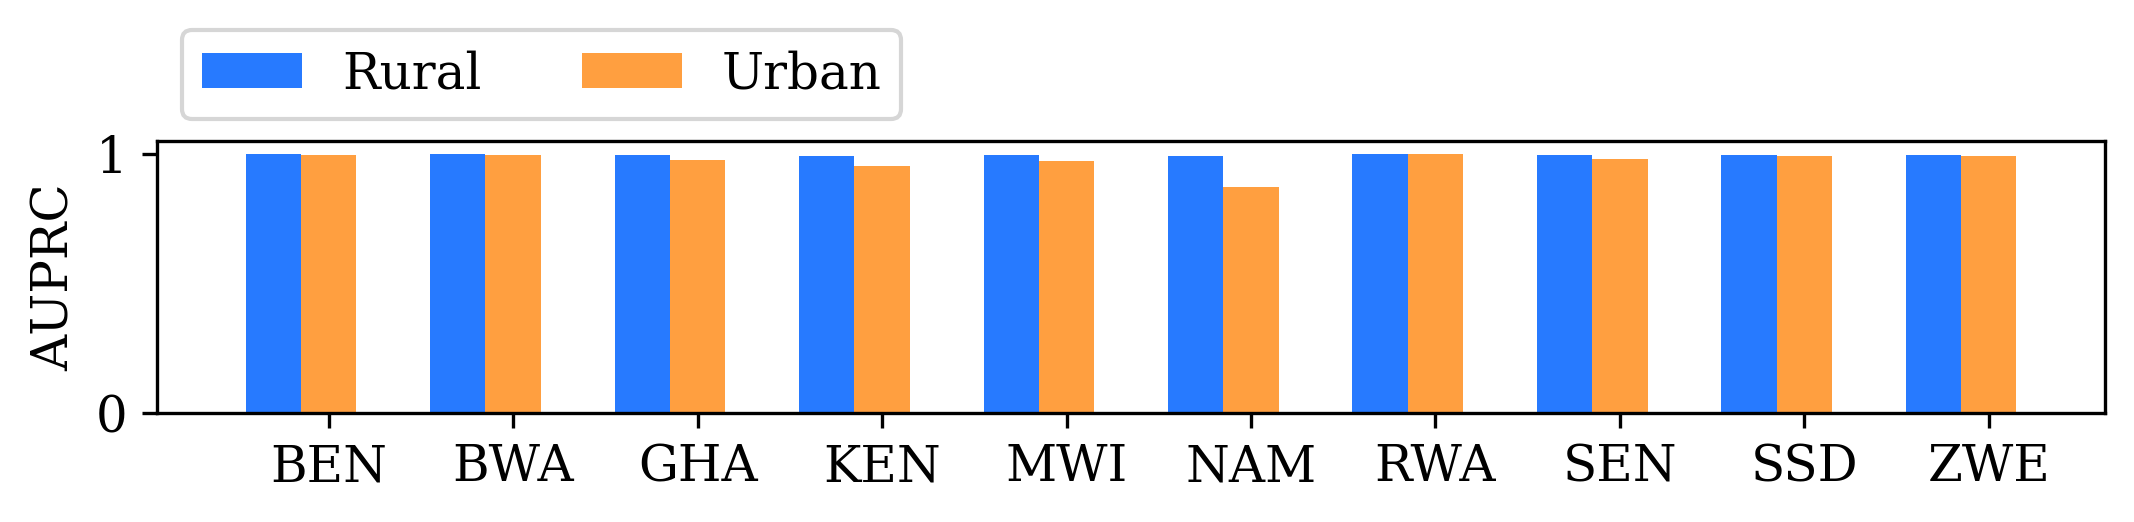

In [15]:
plot_utils.plot_rurban(data_config)

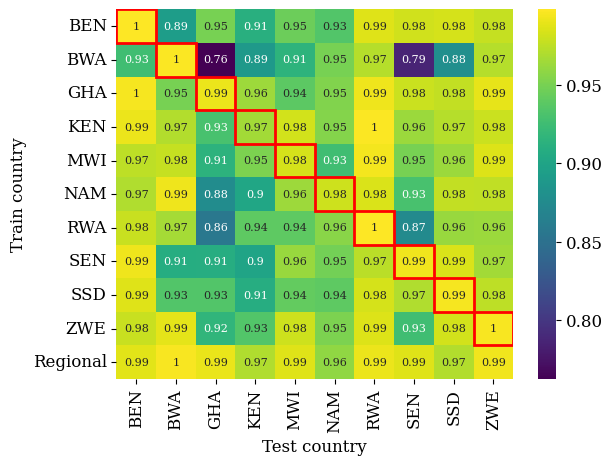

In [11]:
exp_dir = os.path.join(os.getcwd(), "cv")
plot_utils.plot_heatmap(data_config, exp_dir)

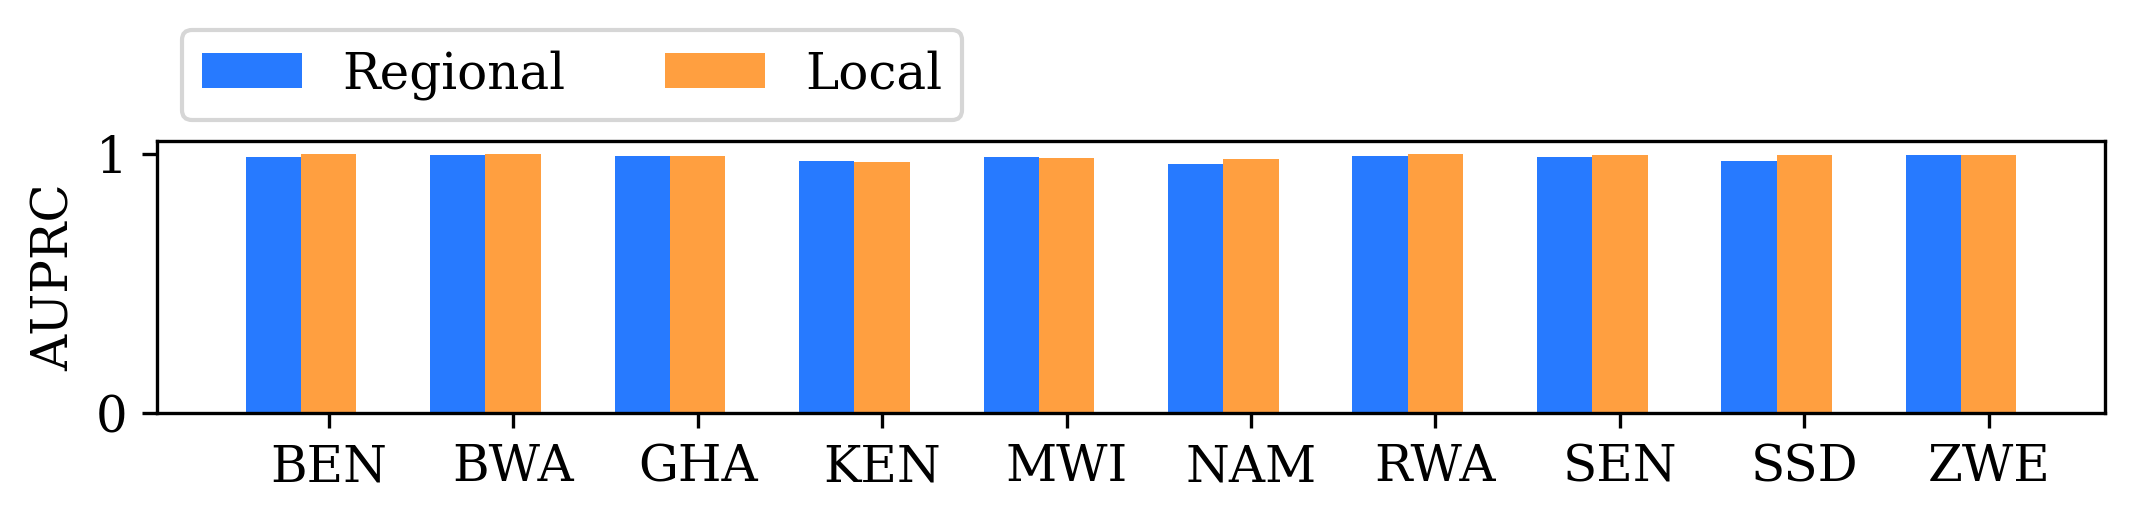

In [13]:
plot_utils.plot_regional_vs_country(data_config, regional_code="AF");